## Model Evaluation Report

### Overview of the prediction algorithm

This model uses a machine learning algorithm called **gradient boosting**, which is a high-performing and efficient prediction algorithm for tabular data, such as our wine dataset.  This is a type of ensemble method, which combines the predictions of several models.

Gradient boosting goes through cycles to iteratively add decision tree models into an ensemble.  It begins by initializing the ensemble with a single model, whose predictions can be pretty naive.  Even if its predictions are wildly inaccurate, subsequent additions to the ensemble will address those errors.

Here is a general overview of the cycle:
- First, we use the current ensemble to generate predictions for each observation in the dataset.  To make a prediction, we add the predictions from all models in the ensemble.  
- These predictions are used to calculate a loss function (like [root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation), for example).
- Then, we use the loss function to fit a new model that will be added to the ensemble.  Specifically, we determine model parameters so that adding this new model to the ensemble will reduce the loss.  The "gradient" in "gradient boosting" refers to the fact that we'll use [gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) on the loss function to determine the parameters of this new model.
- Finally, we add the new model to the ensemble, and repeat the cycle until some stopping threshold is met.

<img src='../images/gradient_boost_diagram.png'>

Specifically, we use the **XGBoost** Python library, which stands for **extreme gradient boosting** and is an implementation of gradient boosting with several additional features focused on performance and speed.

### Evaluating the model

In the following sections, we will look at various metrics and a plot to evaluate the performance and suitability of our model on the dataset.  The calculated metrics and displayed plot below were produced with the parameter `random_state=0` when creating the training and validation datasets.  Different random states will create different subsets of the total training data when creating the training and validation sets, but the results below are consistent when tested with different random states.  

#### Mean Absolute Error

Mean Absolute Error (MAE) is the average of the absolute value of all error values (predicted value minus actual value).  It is calculated with the following formula:

<img src='../images/MAE_formula.png'>

In the next code cells, we load the validation data and our trained model to make the wine score predictions on the validation data (the portion of the total dataset that the model has not been trained on and has no knowledge of).  We then take those predictions, along with the actual wine scores from the validation data, to calculate and display the MAE (using a function from the `sklearn` Python library). 

In [1]:
# Import modules
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, r2_score
from xgboost import XGBRegressor

In [16]:
# Set the default path parameters
model_path = 'data_root/model/model.json'
x_valid_path = 'data_root/datasets/X_test.pkl'
y_valid_path = 'data_root/datasets/y_test.pkl'

In [19]:
# Load the validation data and model
X_valid = pd.read_pickle(x_valid_path)
y_valid = pd.read_pickle(y_valid_path)
model_1 = XGBRegressor()
model_1.load_model(model_path)

# Get predictions
predictions_1 = model_1.predict(X_valid)

# Calculate MAE
mae_1 = mean_absolute_error(predictions_1, y_valid)
print("MAE:" , mae_1)

MAE: 1.8436909980773926


At first, a MAE of approximately 1.8 would appear to be very good.  For example, if a predicted wine rating was 90, you can expect the actual wine rating to be within 1.8 points above or below this prediction on average.

If the wine scores ranged from 0 to 100, then this would mean the average error of the predictions is only 1.8% of the total range.  However, the wine score range in this dataset is only 80 to 100.  In the next code cell, we calculate the MAE as a percentage of the total range of wine scores.

In [20]:
# Calculate MAE as % of total range
mae_perc = mae_1 / (y_valid.max() - y_valid.min()) * 100
print("MAE as a % of total range:" , mae_perc, "%")

MAE as a % of total range: 9.218454990386963 %


An average prediction error of 9.2% of the total range of wine scores is concerning.  If the scores did range from 0 to 100, this would be equivalent to a prediction being wrong by 9.2 points in either direction on average.  This suggests that the model is, at best, a moderate predictor of wine scores.

#### R-Squared

R-Squared is a metric that measures how much of the target variable's variation (variation in actual wine scores in this case) is explained by the model and its inputs.  Without going into the nuances of the math, a good simplified version of the formula is:

<img src='../images/r_squared_formula.png'>

"Unexplained Variation" represents the model's prediction error (differences between predicted values and actual values).  "Total Variation" represents the variation in the target variable (differences between actual values and the mean of those actual values).  

R-Squared can have maximum value of 1, which means the model is a perfect predictor of the target variable (Unexplained Variation is 0).  If R-Squared is 0 (Unexplained Variation is equal to Total Variation) or even negative (Unexplained Variation is greater than Total Variation), then the model is a very poor predictor of the target variable.

In the next code cell, we calculate the R-Squared for this model's predictions on the dataset.

In [21]:
# Calculate R-squared
r_squared_1 = r2_score(y_valid, predictions_1)
print("R-Squared:" , r_squared_1)

R-Squared: 0.4289673530698145


An R-Squared of approximately 0.43 means that only 43% of the variation in actual wine scores is explained by our model.  57% remains unexplained and represents the prediction error.  Consistent with the MAE, this suggests that our model is only a moderate predictor of wine scores.

#### Scatter plot of actual vs predicted values

To get a good visual representation of how our model performs, in the next code cell we create and display a scatter plot of actual values against predicted values.

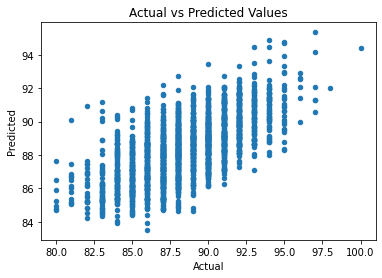

In [22]:
# Create scatter plot of actual vs predicted values
compare_1 = pd.DataFrame({'Actual': y_valid, 'Predicted': predictions_1})
compare_1.plot.scatter('Actual', 'Predicted', title="Actual vs Predicted Values")
plt.show()

The plot is consistent with what we observed with the MAE and R-Squared metrics.  The model appears to be, at best, a moderate predictor of wine scores.  

A general uptrend can be seen (as actual values increase, so do predicted values), which is what we want.  However, there is too much variation in the predictions.  Wines with an actual score of 84 could receive predictions as low as 84 and as high as 90.  Likewise, a prediction of 90 could be for a wine with an actual score as low as 81 or as high as 97.

Ideally, we want the plot to be as close to a straight and narrow increasing line as possible.

### Conclusions

The objective of this model is to optimize wine inventory with the utilization of a wine rating predictor.  Thus, the model's predictions need to be reliable.  The model's MAE, R-Squared and scatter plot of actual versus predicted values suggest the model only provides moderate reliability.  Getting a prediction on a wine rating and having the uncertainty that the actual rating could be several points lower or higher, for a score that only ranges from 80 to 100, will not provide much useful information for optimizing the wine inventory.

However, the model appears to be a good starting point.  It does show some predictive ability and its performance can definitely be increased.  Some potential improvements include:
* **Feature Engineering:** i.e. using natural language processing to extract key words from the "description" column that may be good predictors of wine rating
* **Hyperparameter Tuning:** i.e. using grid-search to find the optimal set of hyperparameters for the model (i.e. number of estimators, learning rate, decision tree depth etc...) to maximize performance
* **Feature Selection:** selecting the best subset of model features based on domain knowledge, statistical measures such as p-value etc...

I recommend making further improvements to the model (including, but not limited to, the suggestions just mentioned above) and seeing improvements in the metrics and scatter plot discussed in this report, before putting the model into full production as a wine rating predictor.